# Plot normalized non-compliance to normalized loading

In [1]:
import sys
import os
import yaml
import numpy as np
#import pandas
from io import StringIO
import pandas as pd
import pathlib
import time
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl

In [2]:
# load setup information
with open('../../etc/SSM_config_whidbey.yaml', 'r') as file:
    ssm = yaml.safe_load(file)
# rename existing and reference tags to match Su Kyong's labels
ssm['run_information']['run_tag']['whidbey']['wqm_baseline'] = "exist"
ssm['run_information']['run_tag']['whidbey']['wqm_reference'] = "ref"

## Load loading spreadsheets for WWTPs and Rivers

In [3]:
# Load excel spreadsheets here and add the river and wwtp totals together
loadings_path = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/reports')
wwtp_loading_df = pd.read_excel(
    loadings_path/'Table1_NutrientLoadings_from_input_whidbey_test2.xlsx',
    sheet_name='WWTP (whidbey)',
    index_col="Unnamed: 0"
)
river_loading_df = pd.read_excel(
    loadings_path/'Table1_NutrientLoadings_from_input_whidbey_test2.xlsx',
    sheet_name='Rivers (whidbey)',
    index_col="Unnamed: 0"
)

## Combine WWTP and River loading across all regions

In [8]:
total_loading = []
for run in [*wwtp_loading_df]:
    total_loading.append(wwtp_loading_df[wwtp_loading_df.index.isin(['Total WWTPs (all in model domain) '])][run].item() +\
                         river_loading_df[river_loading_df.index.isin(['Total Rivers (all in model domain) '])][run].item())

## Combine WWTP and River loading in Whidbey region

In [9]:
total_local_loading = []
for run in [*wwtp_loading_df]:
    total_local_loading.append(wwtp_loading_df[wwtp_loading_df.index.isin(['Total WWTPs (altered in this report)'])][run].item() +\
                         river_loading_df[river_loading_df.index.isin(['Total Rivers (altered in this report)'])][run].item())

## Create dataframe of total loadings for each scenario

In [14]:
total_loading_df = pd.DataFrame(data=np.asarray(total_loading)).T
total_loading_df.columns=[*wwtp_loading_df]
total_loading_df=total_loading_df.rename(index={0:'total loading'})
total_loading_df

,2014 Conditions,Reference,Wtp1,Wtp2,Wtp3,Wtp4,Wtp5,Wtp6,Wtp7,Wtp8,Wr1,Wr2,Wr3,Annual Total Flow (m^3/year)
total loading,5.174897e+07,3.418295e+07,5.053664e+07,5.171112e+07,5.131014e+07,5.101319e+07,5.138437e+07,5.137779e+07,5.174896e+07,5.174668e+07,4.535984e+07,5.073904e+07,5.813810e+07,NaN


In [15]:
total_local_loading_df = pd.DataFrame(data=np.asarray(total_local_loading)).T
total_local_loading_df.columns=[*wwtp_loading_df]
total_local_loading_df=total_local_loading_df.rename(index={0:'total loading'})
total_local_loading_df

,2014 Conditions,Reference,Wtp1,Wtp2,Wtp3,Wtp4,Wtp5,Wtp6,Wtp7,Wtp8,Wr1,Wr2,Wr3,Annual Total Flow (m^3/year)
total loading,7.601597e+06,4.374636e+06,6.389265e+06,7.563743e+06,7.162766e+06,6.865813e+06,7.236998e+06,7.230411e+06,7.601588e+06,7.599305e+06,1.212468e+06,6.591666e+06,1.399072e+07,NaN


## Normalize the loading values by 2014 value

In [16]:
normalized_loading = {}
normalized_local_loading = {}
for run in [*total_loading_df]:
    # use mapping from Hyak to report names (ssm['run_information']['run_tag']['whidbey']) 
    # to get key-values with report names
    normalized_loading[run] = total_loading_df[run]/total_loading_df['2014 Conditions'] 
    normalized_local_loading[run] = total_local_loading_df[run]/total_local_loading_df['2014 Conditions'] 

## Create lists of WWTP runs and River runs

In [17]:
runs_renamed={}
river_runs = ssm['run_information']['Whidbey_rivers']
wwtp_runs = ssm['run_information']['Whidbey_WWTPs']
runs_renamed['rivers']=[ssm['run_information']['run_tag']['whidbey'][key] for key in [*river_runs]]
runs_renamed['wwtp']=[ssm['run_information']['run_tag']['whidbey'][key] for key in [*wwtp_runs]]
runs_renamed['wwtp'].remove('exist')
runs_renamed['wwtp'].remove('ref')
runs_renamed['wwtp'].append('2014 Conditions')
runs_renamed['rivers'].remove('exist')
runs_renamed['rivers'].remove('ref')
runs_renamed['rivers'].append('2014 Conditions')
runs_renamed['base'] = ['2014 Conditions']

# Plot Whidbey region

In [18]:
region = 'Whidbey' # 'ALL_REGIONS' # 

whidbey_nc = pd.read_excel('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/whidbey/spreadsheets/whidbey_wc_noncompliant_m0p25.xlsx',
                           sheet_name='Volume_Days',
                          index_col="Unnamed: 0")
whidbey_vd_norm={}
for run in [*whidbey_nc]:
    whidbey_vd_norm[run] = whidbey_nc[run][region]/whidbey_nc['2014 Conditions'][region]
whidbey_vd_norm

{'2014 Conditions': 1.0,
 'Wtp1': 0.3664581194701929,
 'Wtp2': 0.9789257962301599,
 'Wtp3': 0.6908512907547861,
 'Wtp4': 0.5857632501120774,
 'Wtp5': 0.7403459341069861,
 'Wtp6': 0.799136266718929,
 'Wtp7': 0.8935109010757003,
 'Wtp8': 0.9943864644910764,
 'Wr1': 0.0,
 'Wr2': 0.5966466868889052,
 'Wr3': 10.08500494146997}

In [19]:
N_plot={}
vd_plot={}
for group in ['rivers','wwtp','base']:
    N_plot[group] = np.array([normalized_local_loading[run].item() for run in runs_renamed[group]])
    vd_plot[group] = np.array([whidbey_vd_norm[run].item() for run in runs_renamed[group]])

In [10]:
w_poly={}
rmse={}

# line for WWTPs
w_poly['wwtp']=np.poly1d(np.polyfit(N_plot['wwtp'], vd_plot['wwtp'], 1))
fit_values = w_poly['wwtp'][1]*N_plot['wwtp']+w_poly['wwtp'][0]                                                          
rmse['wwtp']=np.sqrt(np.mean((vd_plot['wwtp']-fit_values)**2))
print('rmse wwtps: ', rmse['wwtp'])

rmse wwtps:  0.02169320775190706


# Plot WWTP and Rivers together

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


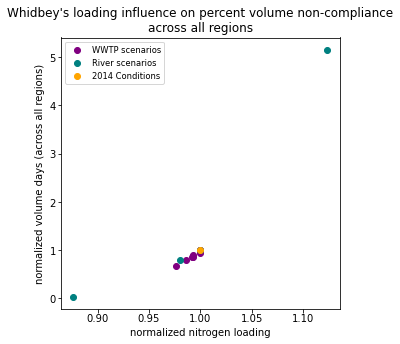

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5),
       gridspec_kw={
           'width_ratios': [1],
           'height_ratios': [1],
       'wspace': 0.25,
       'hspace': 0.15})
# plot up wwtp scenarios 
ax.scatter(N_plot['wwtp'],vd_plot['wwtp'],color='purple',label='WWTP scenarios')
# plot river scenarios
ax.scatter(N_plot['rivers'],vd_plot['rivers'],color='teal',label='River scenarios')
# plot 2014
ax.scatter(N_plot['base'],vd_plot['base'],color='orange',label='2014 Conditions')

# # add WWTP run labels to graphic
# [ax.text(x=N_plot['wwtp'][idx]+.001, y=vd_plot['wwtp'][idx]-.02, s=run_name) for idx,run_name in enumerate(runs_renamed['wwtp'][0:7])]
# ax.text(x=N_plot['wwtp'][7]-.005, y=vd_plot['wwtp'][7]+.01, s=runs_renamed['wwtp'][7])
# ax.text(x=N_plot['wwtp'][8]+.001, y=vd_plot['wwtp'][8]+.008, s=runs_renamed['wwtp'][8])
# # add River run labels to graphic
# [ax.text(x=N_plot['rivers'][idx]+.005, y=vd_plot['rivers'][idx]-.5, s=run_name) for idx,run_name in enumerate(runs_renamed['rivers'][0:3])]
# ax.text(x=N_plot['rivers'][3]+.005, y=vd_plot['rivers'][3]-.25, s=runs_renamed['rivers'][3]) 

# legends and labels
ax.legend(loc='upper left')#bbox_to_anchor=(1,1),loc='upper left')
ax.set_xlabel('normalized nitrogen loading')
# ax.set_xlim(0.97,1.01)
# ax.set_ylim(0.3,1.1)
ax.set_title("Whidbey's loading influence on percent volume non-compliance\nacross all regions")
if region == "ALL_REGIONS":
    ax.set_ylabel(f'normalized volume days (across all regions)')
else:
    ax.set_ylabel(f'normalized volume days ({region.lower()})')
    
plt.savefig(f'/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/graphics/line_fits/whidbey_nitrogen_volumedays_fit_{region}.png', bbox_inches='tight', format='png', dpi=1000)

# Plot WWTP and Rivers separately for Whidbey region

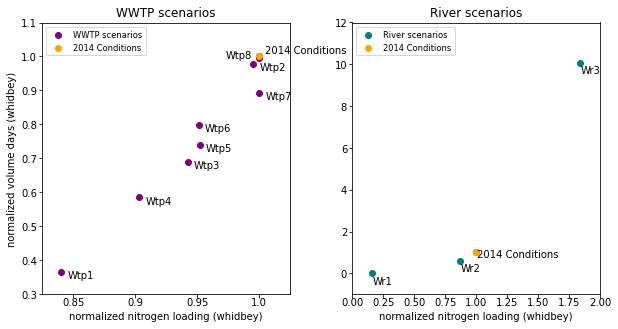

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5),
       gridspec_kw={
           'width_ratios': [1,1],
           'height_ratios': [1],
       'wspace': 0.25,
       'hspace': 0.15})

# plot up wwtp scenarios 
ax[0].scatter(N_plot['wwtp'],vd_plot['wwtp'],color='purple',label='WWTP scenarios')
ax[0].scatter(N_plot['base'],vd_plot['base'],color='orange',label='2014 Conditions')
# add run labels to graphic
[ax[0].text(x=N_plot['wwtp'][idx]+.005, y=vd_plot['wwtp'][idx]-.02, s=run_name) for idx,run_name in enumerate(runs_renamed['wwtp'][0:7])]
ax[0].text(x=N_plot['wwtp'][7]-.027, y=vd_plot['wwtp'][7], s=runs_renamed['wwtp'][7])
ax[0].text(x=N_plot['wwtp'][8]+.005, y=vd_plot['wwtp'][8]+.008, s=runs_renamed['wwtp'][8])
# legends and labels
ax[0].legend(loc='upper left')#bbox_to_anchor=(1,1),loc='upper left')
ax[0].set_xlim(0.825,1.025)
ax[0].set_ylim(0.3,1.1)
ax[0].set_title('WWTP scenarios')
if region == "ALL_REGIONS":
    ax[0].set_ylabel(f'normalized volume days (across all regions)')
    ax[0].set_xlabel('normalized nitrogen loading\n(across all regions)')
    ax[1].set_xlabel('normalized nitrogen loading\n(across all regions)')
else:
    ax[0].set_ylabel(f'normalized volume days ({region.lower()})')
    ax[0].set_xlabel(f'normalized nitrogen loading ({region.lower()})')
    ax[1].set_xlabel(f'normalized nitrogen loading ({region.lower()})')
    
# plot river scenarios
ax[1].scatter(N_plot['rivers'],vd_plot['rivers'],color='teal',label='River scenarios')
ax[1].scatter(N_plot['base'],vd_plot['base'],color='orange',label='2014 Conditions')

xpoints = np.arange(0.85,1.15,0.01)

# add run labels to graphic
[ax[1].text(x=N_plot['rivers'][idx]+.005, y=vd_plot['rivers'][idx]-.5, s=run_name) for idx,run_name in enumerate(runs_renamed['rivers'][0:3])]
ax[1].text(x=N_plot['rivers'][3]+.005, y=vd_plot['rivers'][3]-.25, s=runs_renamed['rivers'][3]) 

#legends and labels
ax[1].legend(loc='upper left')#bbox_to_anchor=(1,1),loc='upper left')

ax[0].set_xticks([0.85, 0.9, 0.95, 1.0])
ax[0].set_xticklabels([0.85, 0.9, 0.95, 1.0])
ax[1].set_xlim(0, 2)
ax[1].set_ylim(-1, 12)
ax[1].set_title('River scenarios')
plt.savefig(f'/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/graphics/line_fits/whidbey_nitrogen_volumedays_fit_{region}_2panel.png', bbox_inches='tight', format='png', dpi=1000)

# Plot WWTPs and Rivers together using ALL REGION non-compliance

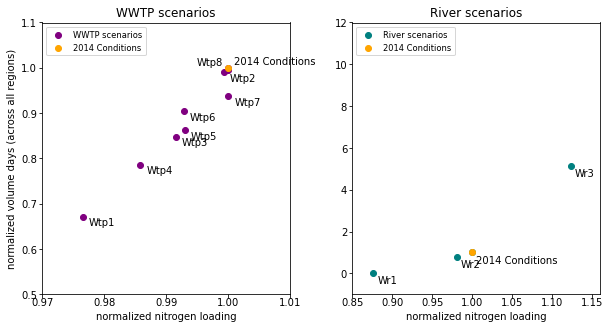

In [14]:
region = 'ALL_REGIONS' # 

whidbey_nc = pd.read_excel('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/whidbey/spreadsheets/whidbey_wc_noncompliant_m0p25.xlsx',
                           sheet_name='Volume_Days',
                          index_col="Unnamed: 0")
whidbey_vd_norm={}
for run in [*whidbey_nc]:
    whidbey_vd_norm[run] = whidbey_nc[run][region]/whidbey_nc['2014 Conditions'][region]
whidbey_vd_norm

N_plot={}
vd_plot={}
for group in ['rivers','wwtp','base']:
    N_plot[group] = np.array([normalized_loading[run].item() for run in runs_renamed[group]])
    vd_plot[group] = np.array([whidbey_vd_norm[run].item() for run in runs_renamed[group]])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5),
       gridspec_kw={
           'width_ratios': [1,1],
           'height_ratios': [1],
       'wspace': 0.25,
       'hspace': 0.15})
# plot up wwtp scenarios 
ax[0].scatter(N_plot['wwtp'],vd_plot['wwtp'],color='purple',label='WWTP scenarios')
ax[0].scatter(N_plot['base'],vd_plot['base'],color='orange',label='2014 Conditions')

# add run labels to graphic
[ax[0].text(x=N_plot['wwtp'][idx]+.001, y=vd_plot['wwtp'][idx]-.02, s=run_name) for idx,run_name in enumerate(runs_renamed['wwtp'][0:7])]
ax[0].text(x=N_plot['wwtp'][7]-.005, y=vd_plot['wwtp'][7]+.01, s=runs_renamed['wwtp'][7])
ax[0].text(x=N_plot['wwtp'][8]+.001, y=vd_plot['wwtp'][8]+.008, s=runs_renamed['wwtp'][8])

# legends and labels
ax[0].legend(loc='upper left')#bbox_to_anchor=(1,1),loc='upper left')
ax[0].set_xlabel('normalized nitrogen loading')
ax[0].set_xlim(0.97,1.01)
ax[0].set_ylim(0.3,1.1)
if region != "Whidbey":
    ax[0].set_ylim(0.5,1.1)
ax[0].set_title('WWTP scenarios')
if region == "ALL_REGIONS":
    ax[0].set_ylabel(f'normalized volume days (across all regions)')
else:
    ax[0].set_ylabel(f'normalized volume days ({region.lower()})')
    
# plot river scenarios
ax[1].scatter(N_plot['rivers'],vd_plot['rivers'],color='teal',label='River scenarios')
ax[1].scatter(N_plot['base'],vd_plot['base'],color='orange',label='2014 Conditions')

xpoints = np.arange(0.85,1.15,0.01)

# add run labels to graphic
[ax[1].text(x=N_plot['rivers'][idx]+.005, y=vd_plot['rivers'][idx]-.5, s=run_name) for idx,run_name in enumerate(runs_renamed['rivers'])]

#legends and labels
ax[1].legend(loc='upper left')#bbox_to_anchor=(1,1),loc='upper left')
ax[1].set_xlabel('normalized nitrogen loading')
ax[1].set_xlim(0.85, 1.16)
ax[1].set_ylim(-1, 12)
ax[1].set_title('River scenarios')
plt.savefig(f'/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/graphics/line_fits/whidbey_nitrogen_volumedays_fit_{region}_2panel.png', bbox_inches='tight', format='png', dpi=1000)

# Same as the above but with line fits
Functional relationships can be established by fitting functions to the data and using some sort of error metric to show goodness of fit. Here, I use root mean square error (RMSE). Zero RMSE indicates a perfect fit and values closer to zero indicate that the functional relationship represents the data points well. Caution: The number of points on hand are not sufficient to establish a relationship. Any functional relationships shown here are for the purpose of asking additional questions to better understand the cause(s) for these relationships.

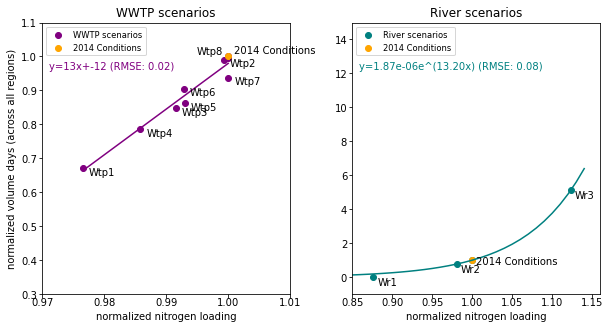

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5),
       gridspec_kw={
           'width_ratios': [1,1],
           'height_ratios': [1],
       'wspace': 0.25,
       'hspace': 0.15})
# plot up wwtp scenarios 
ax[0].scatter(N_plot['wwtp'],vd_plot['wwtp'],color='purple',label='WWTP scenarios')
ax[0].scatter(N_plot['base'],vd_plot['base'],color='orange',label='2014 Conditions')
ax[0].plot(
    np.unique(N_plot['wwtp']), 
    np.poly1d(np.polyfit(N_plot['wwtp'].T, vd_plot['wwtp'], 1))(np.unique(N_plot['wwtp'].T)), 
    color='purple'
)

# add text for line fit
fig.text(.135,0.75,f"y={w_poly['wwtp'][1]:2.0f}x+{w_poly['wwtp'][0]:2.0f} (RMSE: {rmse['wwtp']:.2f})",color='purple')
# add run labels to graphic
[ax[0].text(x=N_plot['wwtp'][idx]+.001, y=vd_plot['wwtp'][idx]-.02, s=run_name) for idx,run_name in enumerate(runs_renamed['wwtp'][0:7])]
ax[0].text(x=N_plot['wwtp'][7]-.005, y=vd_plot['wwtp'][7]+.01, s=runs_renamed['wwtp'][7])
ax[0].text(x=N_plot['wwtp'][8]+.001, y=vd_plot['wwtp'][8]+.008, s=runs_renamed['wwtp'][8])

# legends and labels
ax[0].legend(loc='upper left')#bbox_to_anchor=(1,1),loc='upper left')
ax[0].set_xlabel('normalized nitrogen loading')
ax[0].set_xlim(0.97,1.01)
ax[0].set_ylim(0.3,1.1)
ax[0].set_title('WWTP scenarios')
if region == "ALL_REGIONS":
    ax[0].set_ylabel(f'normalized volume days (across all regions)')
else:
    ax[0].set_ylabel(f'normalized volume days ({region.lower()})')
    
# plot river scenarios
ax[1].scatter(N_plot['rivers'],vd_plot['rivers'],color='teal',label='River scenarios')
ax[1].scatter(N_plot['base'],vd_plot['base'],color='orange',label='2014 Conditions')

# Create exponential fit
C = np.polyfit(N_plot['rivers'][[1,2,3]], np.log(vd_plot['rivers'][[1,2,3]]), 1)
xpoints = np.arange(0.85,1.15,0.01)
river_fit = (
    np.exp(C[1])* 
    np.exp(C[0]*xpoints)
)
ax[1].plot(xpoints,river_fit, 
    color='teal'
)
fit_values = np.exp(C[1])*np.exp(C[0]*N_plot['rivers'])
rmse['rivers']=np.sqrt(np.mean((vd_plot['rivers']-fit_values)**2))
# add text for line fit
fig.text(.565,0.75,f"y={np.exp(C[1]):.02e}e^({C[0]:.02f}x) (RMSE: {rmse['rivers']:.2f})",color='teal')
# add run labels to graphic
[ax[1].text(x=N_plot['rivers'][idx]+.005, y=vd_plot['rivers'][idx]-.5, s=run_name) for idx,run_name in enumerate(runs_renamed['rivers'][0:3])]
ax[1].text(x=N_plot['rivers'][3]+.005, y=vd_plot['rivers'][3]-.25, s=runs_renamed['rivers'][3]) 

#legends and labels
ax[1].legend(loc='upper left')#bbox_to_anchor=(1,1),loc='upper left')
ax[1].set_xlabel('normalized nitrogen loading')
ax[1].set_xlim(0.85, 1.16)
ax[1].set_ylim(-1, 15)
ax[1].set_title('River scenarios')
plt.savefig(f'/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/graphics/line_fits/whidbey_nitrogen_volumedays_fit_{region}_2panel_exp.png', bbox_inches='tight', format='png', dpi=1000)

Caution: The number of points on hand are not sufficient to give confidence that this relationship can be generalized. More research is needed to establish that confidence.  Any functional relationships shown here are for the purpose of asking additional questions to better understand the cause(s) for these relationships. That said, it makes sense that river-sourced nitrogen loading would have a stronger impact than non-river sourced loading because of the additional stratification that comes with a river-sourced loading. 

## Plot using Whidbey for normalized volume days values

rmse wwtps:  0.038440781488135914


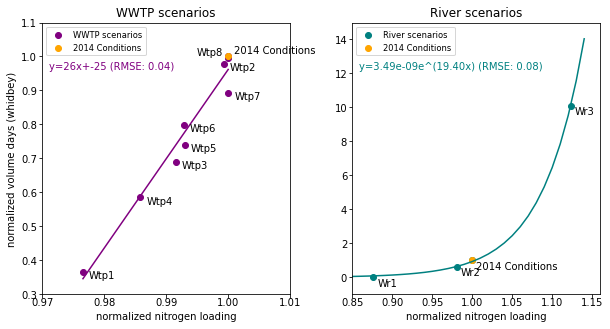

In [16]:
region = 'Whidbey' # 

whidbey_nc = pd.read_excel('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/whidbey/spreadsheets/whidbey_wc_noncompliant_m0p25.xlsx',
                           sheet_name='Volume_Days',
                          index_col="Unnamed: 0")
whidbey_vd_norm={}
for run in [*whidbey_nc]:
    whidbey_vd_norm[run] = whidbey_nc[run][region]/whidbey_nc['2014 Conditions'][region]
whidbey_vd_norm

N_plot={}
vd_plot={}
for group in ['rivers','wwtp','base']:
    N_plot[group] = np.array([normalized_loading[run].item() for run in runs_renamed[group]])
    vd_plot[group] = np.array([whidbey_vd_norm[run].item() for run in runs_renamed[group]])
    
    
w_poly={}
rmse={}

# line for WWTPs
w_poly['wwtp']=np.poly1d(np.polyfit(N_plot['wwtp'], vd_plot['wwtp'], 1))
fit_values = w_poly['wwtp'][1]*N_plot['wwtp']+w_poly['wwtp'][0]                                                          
rmse['wwtp']=np.sqrt(np.mean((vd_plot['wwtp']-fit_values)**2))
print('rmse wwtps: ', rmse['wwtp'])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5),
       gridspec_kw={
           'width_ratios': [1,1],
           'height_ratios': [1],
       'wspace': 0.25,
       'hspace': 0.15})
# plot up wwtp scenarios 
ax[0].scatter(N_plot['wwtp'],vd_plot['wwtp'],color='purple',label='WWTP scenarios')
ax[0].scatter(N_plot['base'],vd_plot['base'],color='orange',label='2014 Conditions')
ax[0].plot(
    np.unique(N_plot['wwtp']), 
    np.poly1d(np.polyfit(N_plot['wwtp'].T, vd_plot['wwtp'], 1))(np.unique(N_plot['wwtp'].T)), 
    color='purple'
)
# ax[0].plot(
#     np.unique(N_plot['wwtp'].T), 
#     np.poly1d(np.polyfit(N_plot['wwtp'], vd_plot['wwtp'], 1)), 
#     color='purple'
# )
# add text for line fit
fig.text(.135,0.75,f"y={w_poly['wwtp'][1]:2.0f}x+{w_poly['wwtp'][0]:2.0f} (RMSE: {rmse['wwtp']:.2f})",color='purple')
# add run labels to graphic
[ax[0].text(x=N_plot['wwtp'][idx]+.001, y=vd_plot['wwtp'][idx]-.02, s=run_name) for idx,run_name in enumerate(runs_renamed['wwtp'][0:7])]
ax[0].text(x=N_plot['wwtp'][7]-.005, y=vd_plot['wwtp'][7]+.01, s=runs_renamed['wwtp'][7])
ax[0].text(x=N_plot['wwtp'][8]+.001, y=vd_plot['wwtp'][8]+.008, s=runs_renamed['wwtp'][8])

# legends and labels
ax[0].legend(loc='upper left')#bbox_to_anchor=(1,1),loc='upper left')
ax[0].set_xlabel('normalized nitrogen loading')
ax[0].set_xlim(0.97,1.01)
ax[0].set_ylim(0.3,1.1)
if region != "Whidbey":
    ax[0].set_ylim(0.5,1.1)
ax[0].set_title('WWTP scenarios')
if region == "ALL_REGIONS":
    ax[0].set_ylabel(f'normalized volume days (across all regions)')
else:
    ax[0].set_ylabel(f'normalized volume days ({region.lower()})')
    
# plot river scenarios
ax[1].scatter(N_plot['rivers'],vd_plot['rivers'],color='teal',label='River scenarios')
ax[1].scatter(N_plot['base'],vd_plot['base'],color='orange',label='2014 Conditions')

# Create exponential fit
C = np.polyfit(N_plot['rivers'][[1,2,3]], np.log(vd_plot['rivers'][[1,2,3]]), 1)
xpoints = np.arange(0.85,1.15,0.01)
river_fit = (
    np.exp(C[1])* 
    np.exp(C[0]*xpoints)
)
ax[1].plot(xpoints,river_fit, 
    color='teal'
)
fit_values = np.exp(C[1])*np.exp(C[0]*N_plot['rivers'])
rmse['rivers']=np.sqrt(np.mean((vd_plot['rivers']-fit_values)**2))
# add text for line fit
fig.text(.565,0.75,f"y={np.exp(C[1]):.02e}e^({C[0]:.02f}x) (RMSE: {rmse['rivers']:.2f})",color='teal')
# add run labels to graphic
[ax[1].text(x=N_plot['rivers'][idx]+.005, y=vd_plot['rivers'][idx]-.5, s=run_name) for idx,run_name in enumerate(runs_renamed['rivers'])]

#legends and labels
ax[1].legend(loc='upper left')#bbox_to_anchor=(1,1),loc='upper left')
ax[1].set_xlabel('normalized nitrogen loading')
ax[1].set_xlim(0.85, 1.16)
ax[1].set_ylim(-1, 15)
ax[1].set_title('River scenarios')
plt.savefig(f'/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/graphics/line_fits/whidbey_nitrogen_volumedays_fit_{region}_2panel_exp.png', bbox_inches='tight', format='png', dpi=1000)

Caution: The number of points on hand are not sufficient to give confidence that this relationship can be generalized. More research is needed to establish that confidence.  Any functional relationships shown here are for the purpose of asking additional questions to better understand the cause(s) for these relationships.  That said, it makes sense that river-sourced nitrogen loading would have a stronger impact than non-river sourced loading because of the additional stratification that comes with a river-sourced loading. 

# Plot normalized volume day vs nitrogen loading for different regions

In [17]:
whidbey_nc = pd.read_excel(
    '/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/whidbey/spreadsheets/whidbey_wc_noncompliant_m0p25.xlsx',
    sheet_name='Volume_Days',
    index_col="Unnamed: 0"
)

In [18]:
whidbey_nc.index.to_list()

['Hood',
 'Main',
 'SJF_Admiralty',
 'SOG_Bellingham',
 'South_Sound',
 'Whidbey',
 'ALL_REGIONS']

rmse wwtps:  0.031530585816954185
rmse wwtps:  0.009978734216257733


/tmp/ipykernel_96381/268568441.py:6: RuntimeWarning: invalid value encountered in double_scalars
  whidbey_vd_norm[run] = whidbey_nc[run][region]/whidbey_nc['2014 Conditions'][region]
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


rmse wwtps:  nan


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


rmse wwtps:  0.008395628644141078
rmse wwtps:  0.011082322290913382
rmse wwtps:  0.038440781488135914
rmse wwtps:  0.02169320775190706


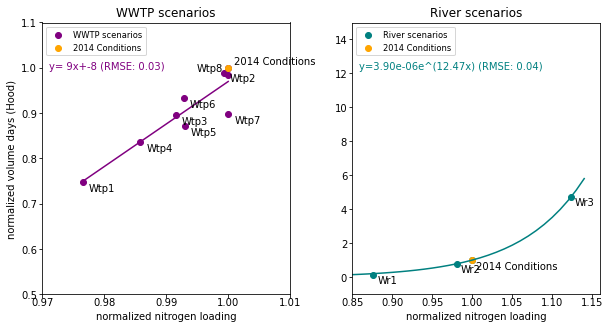

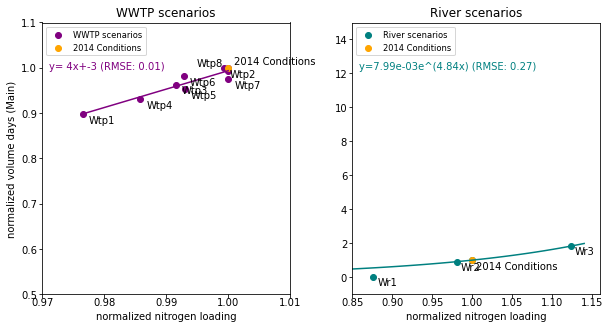

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


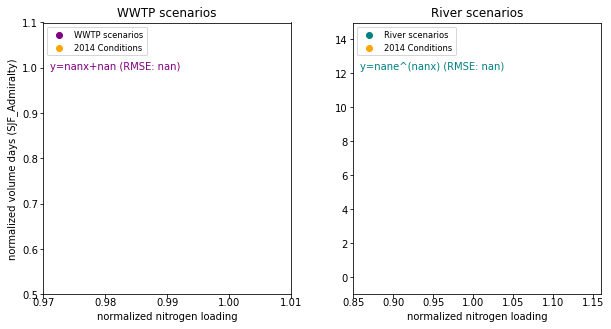

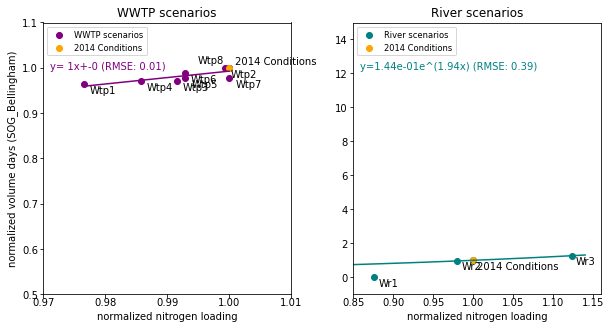

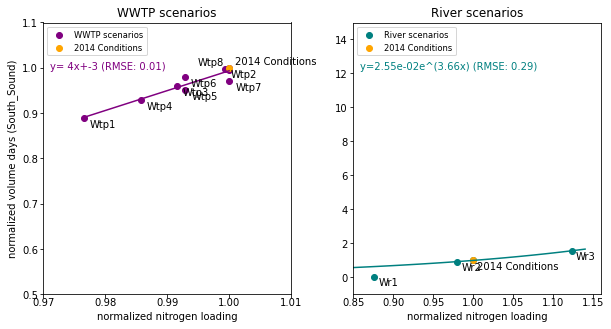

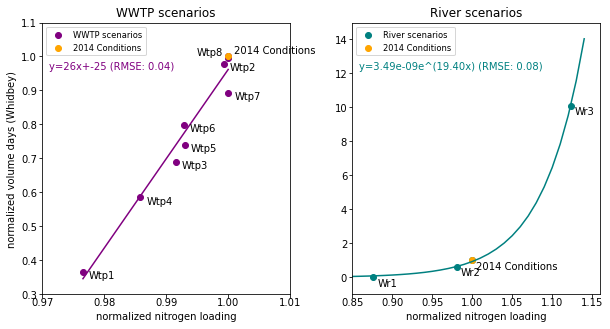

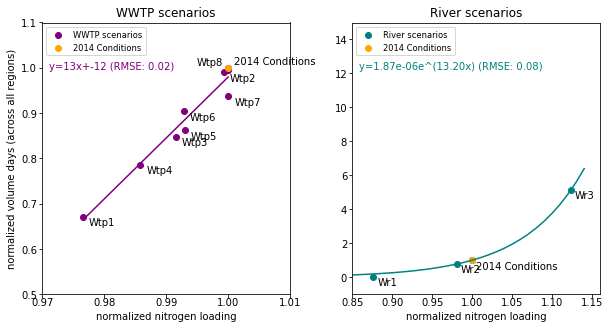

In [19]:
for region in whidbey_nc.index.to_list(): 


    whidbey_vd_norm={}
    for run in [*whidbey_nc]:
        whidbey_vd_norm[run] = whidbey_nc[run][region]/whidbey_nc['2014 Conditions'][region]
    whidbey_vd_norm

    N_plot={}
    vd_plot={}
    for group in ['rivers','wwtp','base']:
        N_plot[group] = np.array([normalized_loading[run].item() for run in runs_renamed[group]])
        vd_plot[group] = np.array([whidbey_vd_norm[run].item() for run in runs_renamed[group]])


    w_poly={}
    rmse={}

    # line for WWTPs
    w_poly['wwtp']=np.poly1d(np.polyfit(N_plot['wwtp'], vd_plot['wwtp'], 1))
    fit_values = w_poly['wwtp'][1]*N_plot['wwtp']+w_poly['wwtp'][0]                                                          
    rmse['wwtp']=np.sqrt(np.mean((vd_plot['wwtp']-fit_values)**2))
    print('rmse wwtps: ', rmse['wwtp'])

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5),
           gridspec_kw={
               'width_ratios': [1,1],
               'height_ratios': [1],
           'wspace': 0.25,
           'hspace': 0.15})
    # plot up wwtp scenarios 
    ax[0].scatter(N_plot['wwtp'],vd_plot['wwtp'],color='purple',label='WWTP scenarios')
    ax[0].scatter(N_plot['base'],vd_plot['base'],color='orange',label='2014 Conditions')
    ax[0].plot(
        np.unique(N_plot['wwtp']), 
        np.poly1d(np.polyfit(N_plot['wwtp'].T, vd_plot['wwtp'], 1))(np.unique(N_plot['wwtp'].T)), 
        color='purple'
    )
    # ax[0].plot(
    #     np.unique(N_plot['wwtp'].T), 
    #     np.poly1d(np.polyfit(N_plot['wwtp'], vd_plot['wwtp'], 1)), 
    #     color='purple'
    # )
    # add text for line fit
    fig.text(.135,0.75,f"y={w_poly['wwtp'][1]:2.0f}x+{w_poly['wwtp'][0]:2.0f} (RMSE: {rmse['wwtp']:.2f})",color='purple')
    # add run labels to graphic
    [ax[0].text(x=N_plot['wwtp'][idx]+.001, y=vd_plot['wwtp'][idx]-.02, s=run_name) for idx,run_name in enumerate(runs_renamed['wwtp'][0:7])]
    ax[0].text(x=N_plot['wwtp'][7]-.005, y=vd_plot['wwtp'][7]+.01, s=runs_renamed['wwtp'][7])
    ax[0].text(x=N_plot['wwtp'][8]+.001, y=vd_plot['wwtp'][8]+.008, s=runs_renamed['wwtp'][8])

    # legends and labels
    ax[0].legend(loc='upper left')#bbox_to_anchor=(1,1),loc='upper left')
    ax[0].set_xlabel('normalized nitrogen loading')
    ax[0].set_xlim(0.97,1.01)
    ax[0].set_ylim(0.3,1.1)
    if region != "Whidbey":
        ax[0].set_ylim(0.5,1.1)
    ax[0].set_title('WWTP scenarios')
    if region == "ALL_REGIONS":
        ax[0].set_ylabel(f'normalized volume days (across all regions)')
    else:
        ax[0].set_ylabel(f'normalized volume days ({region.lower()})')
        ax[0].set_ylabel(f'normalized volume days ({region})')

    # plot river scenarios
    ax[1].scatter(N_plot['rivers'],vd_plot['rivers'],color='teal',label='River scenarios')
    ax[1].scatter(N_plot['base'],vd_plot['base'],color='orange',label='2014 Conditions')

    # Create exponential fit
    C = np.polyfit(N_plot['rivers'][[1,2,3]], np.log(vd_plot['rivers'][[1,2,3]]), 1)
    xpoints = np.arange(0.85,1.15,0.01)
    river_fit = (
        np.exp(C[1])* 
        np.exp(C[0]*xpoints)
    )
    ax[1].plot(xpoints,river_fit, 
        color='teal'
    )
    fit_values = np.exp(C[1])*np.exp(C[0]*N_plot['rivers'])
    rmse['rivers']=np.sqrt(np.mean((vd_plot['rivers']-fit_values)**2))
    # add text for line fit
    fig.text(.565,0.75,f"y={np.exp(C[1]):.02e}e^({C[0]:.02f}x) (RMSE: {rmse['rivers']:.2f})",color='teal')
    # add run labels to graphic
    [ax[1].text(x=N_plot['rivers'][idx]+.005, y=vd_plot['rivers'][idx]-.5, s=run_name) for idx,run_name in enumerate(runs_renamed['rivers'])]

    #legends and labels
    ax[1].legend(loc='upper left')#bbox_to_anchor=(1,1),loc='upper left')
    ax[1].set_xlabel('normalized nitrogen loading')
    ax[1].set_xlim(0.85, 1.16)
    ax[1].set_ylim(-1, 15)
    ax[1].set_title('River scenarios')
    plt.savefig(
        f'/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/graphics/line_fits/whidbey_nitrogen_volumedays_fit_{region}_2panel_exp.png', 
        bbox_inches='tight', 
        format='png', 
        dpi=1000
    )

Caution: The number of points on hand are not sufficient to give confidence that this relationship can be generalized. More research is needed to establish that confidence.  Any functional relationships shown here are for the purpose of asking additional questions to better understand the cause(s) for these relationships.